# 👽👾 `print(fiction)` 📚🛸

> #### A data science project by _Tobias Reaper_

#### 📓 Notebook 3: Modeling 🧠

---

### Notebook Outline

* Intro
* Imports and configuration
* 

---

## Intro

[quick intro to project]

[explanation of this notebook in context of project]

---

### 📥 Initial Imports and Configuration ⚙️

In [1]:
# === General Imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import janitor

In [2]:
# === Configure === #
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [3]:
# === ML Imports === #
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

---

## 📈 Load Data

In [4]:
# === Load the dataset === #
# This version was exported from the previous notebook
# after doing some initial wrangling
data_path = "assets/must_read_books-02.csv"

books = pd.read_csv(data_path, na_values="?")
print(books.shape)
books.head(3)

(18344, 18)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction,republish
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,0,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0,0,1
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,0,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0,0,1
2,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,1,477.0,1521.0,9016.0,25447.0,47472.0,1974.0,1.0,1.0,1,1


In [5]:
# === Confirm null values were read in correctly === #
books.isnull().sum()

title                0
author               0
num_ratings          0
num_reviews          0
avg_rating           0
num_pages          666
language          1332
series               0
1_rating_count      83
2_rating_count      83
3_rating_count      83
4_rating_count      83
5_rating_count      83
publish_year       282
publish_month      282
publish_day        282
fiction              0
republish            0
dtype: int64

---

## Model validation

* Split data into train, validation, and test sets
* Choose an appropriate evaluation metric
* Get a baseline accuracy (or precision/recall)

In [13]:
# === Split up data into train / val / test === #
train, test = train_test_split(books, stratify=books["fiction"], test_size=0.2, random_state=92)
train, val = train_test_split(train, stratify=train["fiction"], test_size=0.2, random_state=92)

train.shape, val.shape, test.shape
# train.shape, test.shape

((11740, 18), (2935, 18), (3669, 18))

In [14]:
# === Set up target and features === #

target = "fiction"

# Arrange y vector
y_train = train[target]
y_val = val[target]
y_test = test[target]

print(y_train.shape, y_val.shape, y_test.shape)
# print(y_train.shape, y_test.shape)

# Arrange X matrices
X_train = train.drop(columns=[target])
X_val = val.drop(columns=[target])
X_test = test.drop(columns=[target])

print(X_train.shape, X_val.shape, X_test.shape)
# print(X_train.shape, X_test.shape)

(11740,) (2935,) (3669,)
(11740, 17) (2935, 17) (3669, 17)


1    6145
0    5595
Name: fiction, dtype: int64


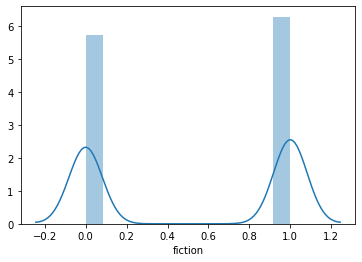

In [15]:
# === Target distribution === #
print(y_train.value_counts())
sns.distplot(y_train);

#### Majority class baseline

In [11]:
# === Use mode as predictions === #
maj = y_train.mode()[0]  # Mode is 1 (fiction)

# Simply predict 1 for every training example
y_pred_maj = [maj] * len(y_train)

# Baseline accuracy
accuracy_score(y_train, y_pred_maj)

0.5234071550255537

#### Limited logistic baseline

In [16]:
# === Use only a few features for this baseline === #
base_features = [
    "num_reviews",
    "avg_rating",
    "num_pages",
]

# Arrange X matrices
X1_train = train[base_features]
X1_val = val[base_features]
X1_test = test[base_features]

X1_train.shape, X1_val.shape, X1_test.shape
# X1_train.shape, X1_test.shape

((11740, 3), (2935, 3), (3669, 3))

In [18]:
# === Baseline model === #
pipe1 = Pipeline([
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median")),
    ("logreg", LogisticRegression(random_state=92)),
])

# Train base pipeline
pipe1.fit(X1_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('logreg', LogisticRegression(random_state=92))])

In [19]:
# === Made predictions to get validation accuracy === #
y_pred1 = pipe1.predict(X1_val)

# Compute accuracy
print("Baseline accuracy:", accuracy_score(y_val, y_pred1))

Baseline accuracy: 0.6275979557069846


In [20]:
# === Baseline confusion matrix === #
confusion_matrix(y_val, y_pred1)

array([[ 821,  578],
       [ 515, 1021]])

#### Default Random Forest

In [21]:
# === Default random forest model === #

def_drop_columns = [
    "title",
    "author",
    "language",
]

X2_train = X_train.drop(columns=def_drop_columns)
X2_val = X_val.drop(columns=def_drop_columns)
X2_test = X_test.drop(columns=def_drop_columns)

rf1_pipe2 = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf1_pipe.fit(X2_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf1 = rf1_pipe.predict(X2_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf1))
print("  F1 score:", f1_score(y_val, y_pred_rf1))

Default random forest eval metrics:
  Accuracy: 0.7342419080068143
  F1 score: 0.7477360931435963


In [22]:
# === Baseline confusion matrix === #
confusion_matrix(y_val, y_pred_rf1)

array([[ 999,  400],
       [ 380, 1156]])

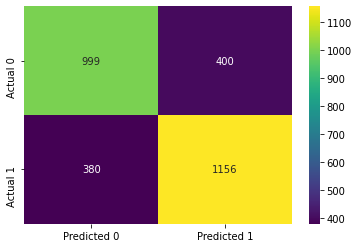

In [26]:
from sklearn.utils.multiclass import unique_labels

unique_labels(y_val)

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred_rf1);

Alrighty then! With the (almost) full set of features and default hyperparameters the target can be predicted with ~73% accuracy. Although the target is not skewed very much, it is still skewed. Therefore, accuracy may not be the best way to evaluate the model. A better metric could be the f1 score. This is a little higher than the accuracy, clocking in at almost 75%.

Let's see what we can do to increase that score.

---

## Iterate

* Use cross-validation to tune hyperparameters
* Engineer more features
* Iterate

#### Cross-validation + Hyperparameter tuning

In [31]:
# === Random forest, Part 2 === #
# Tune hyperparameters using cross-validation

def_drop_columns = [
    "title",
    "author",
    "language",
]

X3_train = X_train.drop(columns=def_drop_columns)
X3_test = X_test.drop(columns=def_drop_columns)

rf2_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

rf2_params = {
    
}

# Train default random forest
rf2_pipe.fit(X2_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf2 = rf1_pipe.predict(X2_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf2))
print("  F1 score:", f1_score(y_val, y_pred_rf2))

Default random forest eval metrics:
  Accuracy: 0.7342419080068143
  F1 score: 0.7477360931435963
